# 0.0 Imports

In [1]:
import math
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
import datetime
from IPython.core.display import HTML


## 0.1 Helper functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False )

In [5]:
df_sales_raw.shape

(1017209, 9)

In [6]:
df_store_raw = pd.read_csv('data/store.csv', low_memory = False )

In [7]:
df_store_raw.shape

(1115, 10)

In [8]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [9]:
df_raw.shape

(1017209, 18)

In [10]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
435952,773,5,2014-06-06,5671,864,1,1,0,0,a,a,200.0,NaN,NaN,0,NaN,NaN,NaN


# 1.0 Passo 1 - Descrição dos dados

## 1.1 Renomear colunas

In [11]:
df1 = df_raw.copy()
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
# modificando nomes das colunas
snakecase = lambda x: inflection.underscore(x)
cols_new=list(map(snakecase, cols_old))
df1.columns = cols_new

## 1.2 Data dimensions

In [12]:
print(f'Linhas: {df1.shape[0]}. Colunas: {df1.shape[1]}')

Linhas: 1017209. Colunas: 18


## 1.3 Data types

In [13]:
df1['date']=pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [14]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [15]:
df1['competition_distance'].max()

75860.0

In [16]:
#competition_distance   
# preenchendo NA com valor grande assumindo que se é NA é porque o copetidor mais próximo está muito longe
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)
#competition_open_since_month 
df1['competition_open_since_month'] =df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
#competition_open_since_year  
df1['competition_open_since_year'] =df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


In [17]:
#promo2                       
#promo2_since_week   
df1['promo2_since_week'] =df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year  
df1['promo2_since_year'] =df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval        
month_map = {1:'Jan' ,2:'Feb' ,3:'Mar' ,4:'Apr' ,5:'May' ,6:'Jun' ,7:'Jul' ,8:'Aug' ,9:'Sep' ,10:'Oct' ,11:'Nov' ,12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis =1)

In [18]:
df1.sample(5).T

,894917,272090,199225,327767,981866
store,358,224,756,832,337
day_of_week,6,7,2,4,5
date,2013-04-20 00:00:00,2014-11-23 00:00:00,2015-02-03 00:00:00,2014-09-25 00:00:00,2013-02-01 00:00:00
sales,8725,0,17754,4745,4387
customers,1064,0,2305,469,340
open,1,0,1,1,1
promo,0,0,1,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,d,a,d,d


In [19]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change types

In [20]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [21]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [22]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive statistical

In [23]:
#Separndo colunas de dados numéricos e categóricos
num_attributes = df1.select_dtypes(include=['int32', 'int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int32', 'int64', 'float64', 'datetime64[ns]'])

In [24]:
cat_attributes.sample()

,state_holiday,store_type,assortment,promo_interval,month_map
615962,c,a,a,"Feb,May,Aug,Nov",Dec


### Numerical Attributes

In [25]:
# Central tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
# Dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()



In [26]:
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<Axes: xlabel='sales', ylabel='Count'>

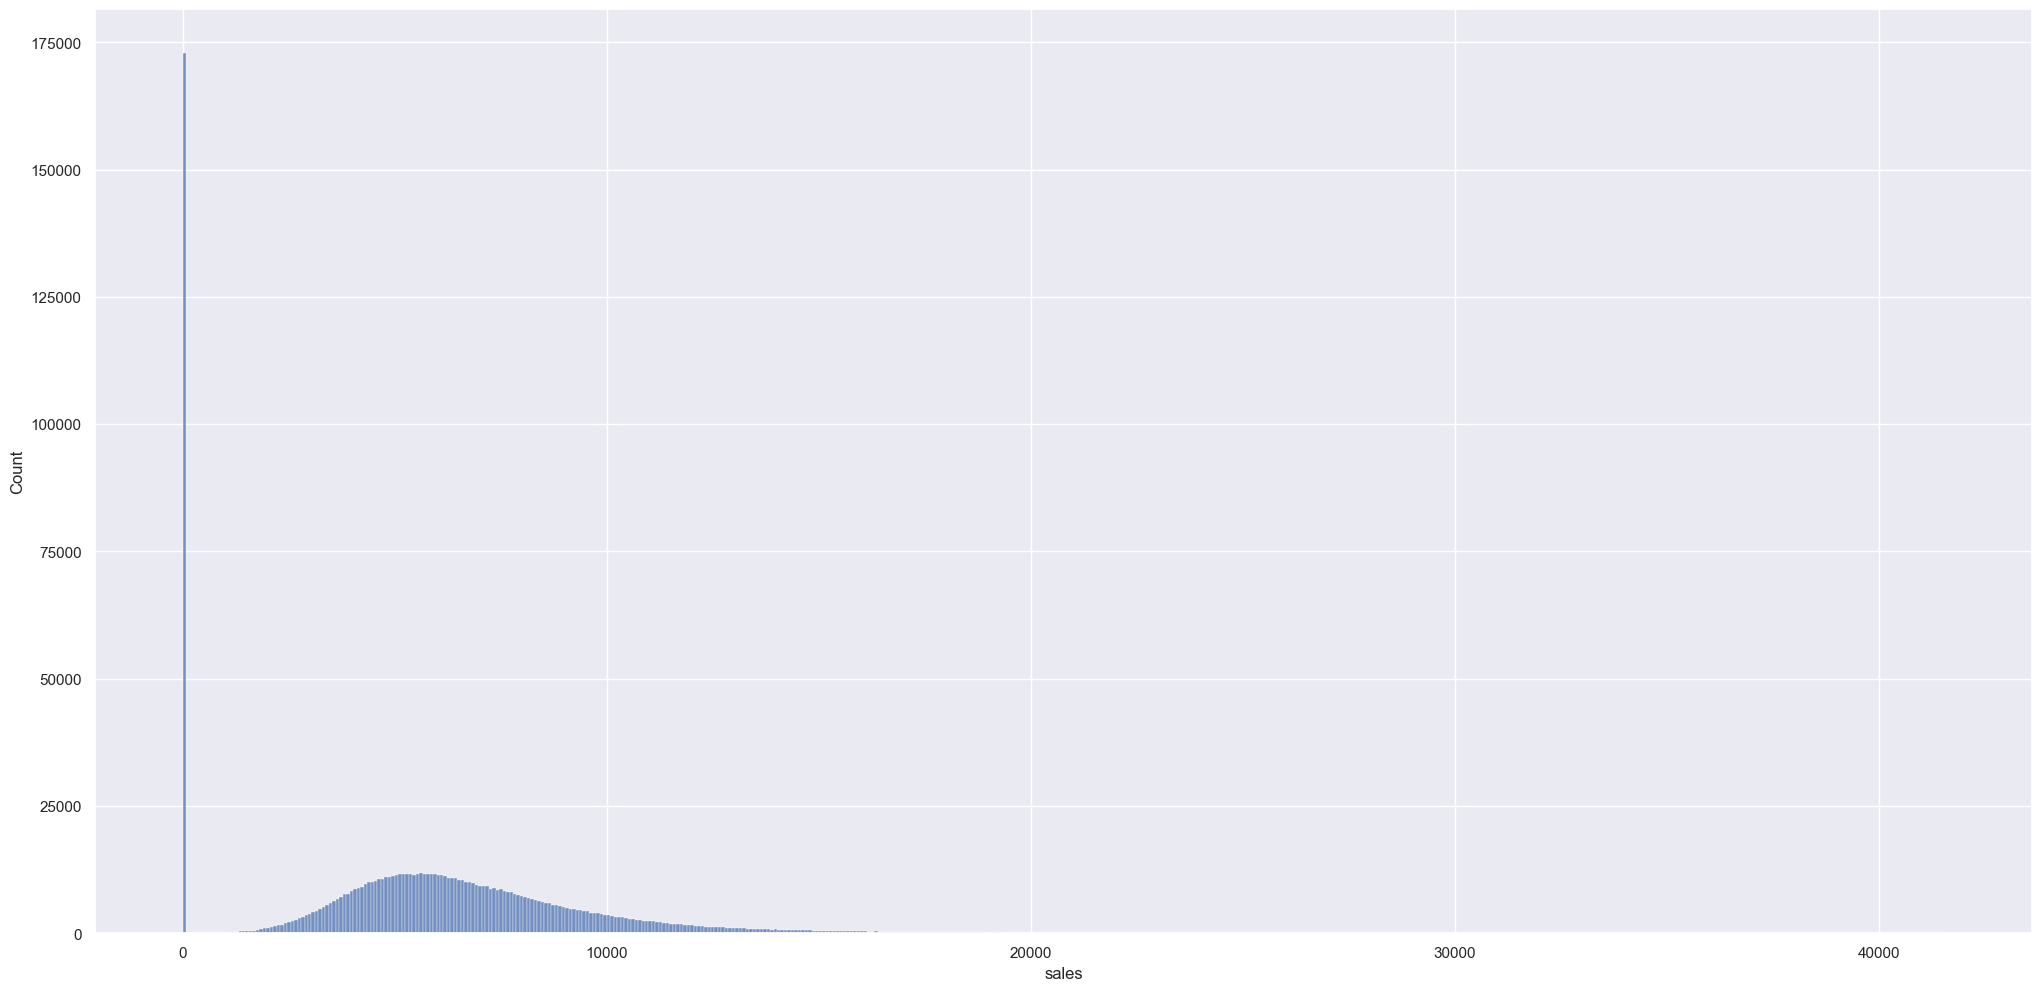

In [27]:
sns.histplot(df1['sales'])

<Axes: xlabel='competition_distance', ylabel='Density'>

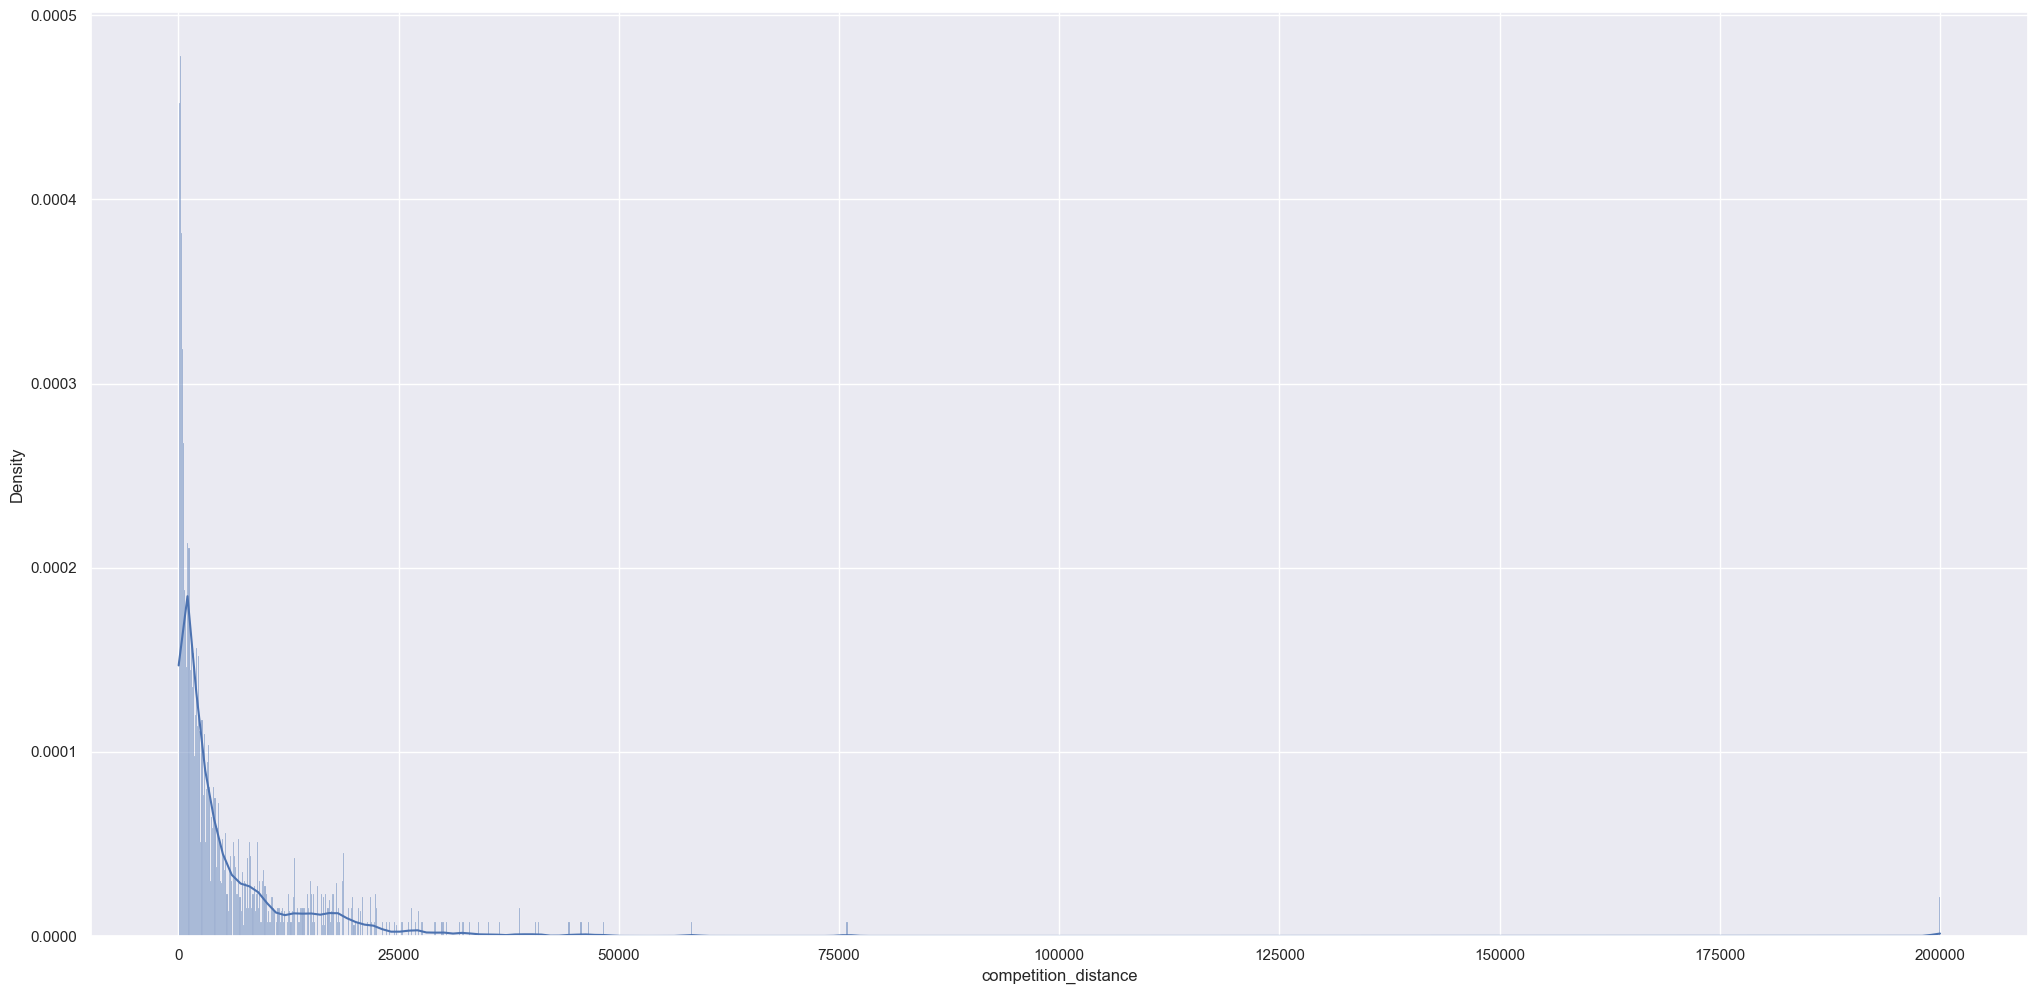

In [28]:
sns.set_theme()
sns.histplot(df1['competition_distance'], kde=True, stat='density')

### 1.7.2 Categorical attributes

In [29]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

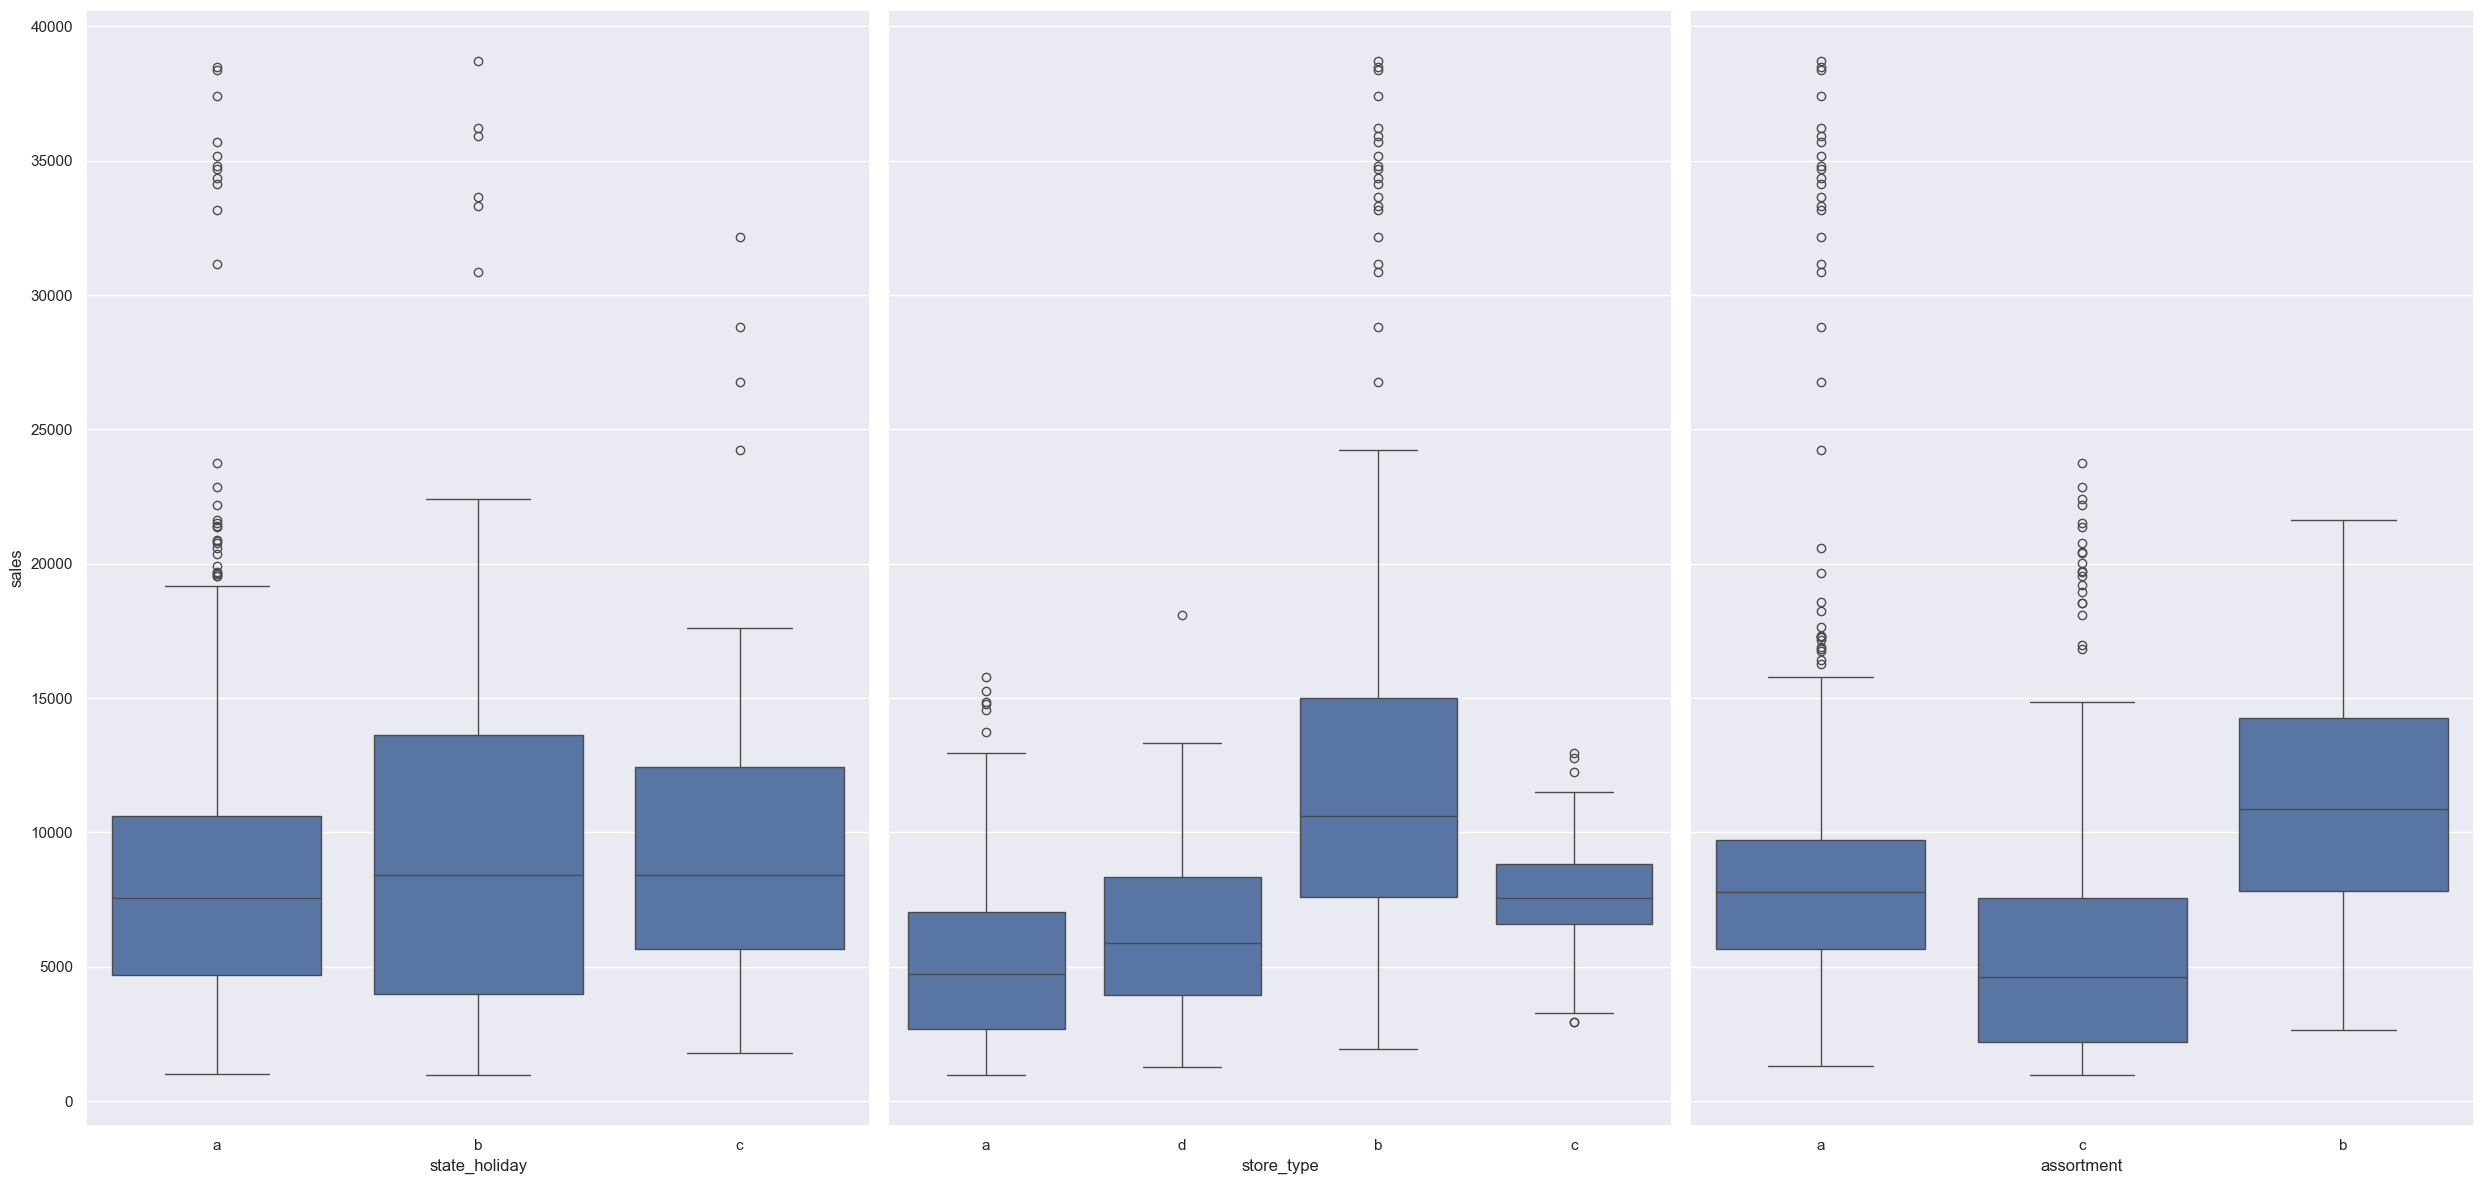

In [30]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data= aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data= aux1)
plt.ylabel('')  # Remove o rótulo 'sales' do eixo Y
plt.gca().set_yticklabels([])  # Remove os valores/ticks do eixo Y

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data= aux1)
plt.ylabel('')  # Remove o rótulo 'sales' do eixo Y
plt.gca().set_yticklabels([])  # Remove os valores/ticks do eixo Y

plt.tight_layout()  # Ajusta o espaçamento entre os gráficos


# 2.0 Passo 2 - Feature Engineering

## 2.1 Mapa mental de hipóteses

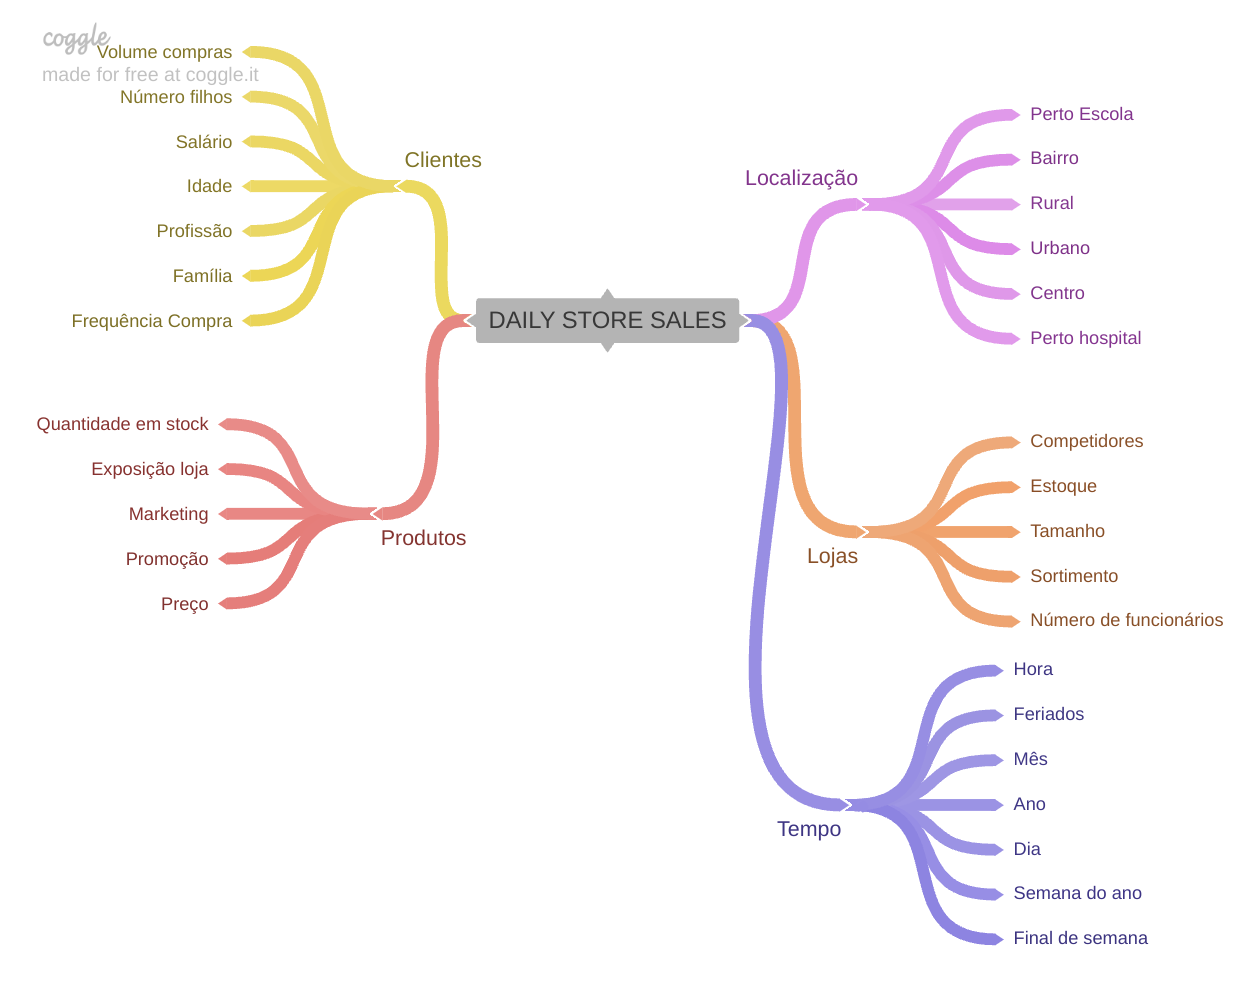

In [31]:
Image('img/DAILY_STORE_SALES.png')

## 2.1.0 Criação das hipóteses

### 2.1.1 Hipóteses Loja

1. Lojas com maior quadro de funcionários deveriam vender mais
2. Lojas com maior estoque deveriam vender mais
3. Lojas com maior porte deveriam vender mais
4. Lojas com maior sortimento deveriam vender mais

### 2.1.2 Hipóteses Produto

1. Produtos que recebem mais investimento de marketing deveriam vender mais
2. Lojas que expõem mais os produtos em vitrine deveriam vender mais
3. Lojas que possuem preços menores nos produtos deveriam vender mais
4. Lojas que tem preços menores nos produtos por mais tempo deveriam vender mais
   

### 2.1.1 Hipóteses Tempo (Sazonalidade)

1. Lojas com mais feriados deveriam vender menos
2. Lojas que abrem nos últimos 6 meses deveriam vender mais
3. Lojas que abrem nos finais de semana deveriam vender mais

## 2.2 Lista final de hipóteses

Filtrar hipóteses com base no critério de haver ou não dados que possam validar/refutar a hipótese

1. Lojas com maior sortimento deveriam vender mais
2. Lojas com competidores mais próximos deveriam vender menos
3. Lojas com competidores a mais tempo deveriam vender menos

4. Lojas com promoções ativas por mais tempo deveriam vender mais
5. Lojas com mais dias de promoção deveriam vender mais
6. Lojas com mais promoçoes consecutivas deveriam vender mais

7. Lojas com mais feriados deveriam vender menos
8. Lojas que abrem nos últimos 6 meses deveriam vender mais
9. Lojas que abrem nos finais de semana deveriam vender mais

## 2.3 Feature Engineering

In [32]:
df2 = df1.copy()

In [33]:
#year
df2['year']=df2['date'].dt.year
#month
df2['month']=df2['date'].dt.month
#day
df2['day']=df2['date'].dt.day
#week of year
df2['week_of_year']=df2['date'].dt.isocalendar().week
#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


In [34]:
#competition since
df2['competition_since'] =df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month=x['competition_open_since_month'] ,day=1 ), axis = 1)
df2['competition_time_month'] =(df2['date'] - df2['competition_since']).apply(lambda x: (x.days)/30).astype(int)
##promo since
df2['promo_since'] =df2['promo2_since_year'].astype(str) +'-'+ df2['promo2_since_week'].astype(str)
df2['promo_since'] =df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x +'-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] =((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)
#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
#state holiday
df2['state_holiday'] =df2['state_holiday'].apply(lambda x : 'public_holiday' if x == 'a' else 'easter_holiday' if x== 'b' else 'christmas' if x== 'c' else 'regular_day')

In [35]:

df_t= ((df2.loc[0:5, 'date'] - df2.loc[0:5, 'competition_since']).apply(lambda x: (x.days)/30)).astype(int)
df_t
#df2.loc[0:5 , 'date']

0     84
1     94
2    105
3     71
4      4
5     20
dtype: int32

In [36]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [37]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int32
month        

# 3.0 Passo 3 - Filtragem de variáveis

In [38]:
df3 = df2.copy()

In [39]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.1 Seleção das linhas
Remover as linhas onde as lojas não estavam abertas e que não tiveram vendas. Pois só intressam linhas com vendas.

In [40]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das colunas
Remover colunas que não vão poder contribuir com a previsão no momento da previsão.
Embora a coluna customers contenha dados, quando for o momento de realmente fazer a previsão, não há como saber quantos clientes fariam compras nas lojas no futuro. Pra isso, teria que se fazer outro projeto de previsão de clientes e então usar esse valor como input na coluna customers.
Exclui a coluna open pois uma vez que tenha excluido linhas com open != 0, já não tem informação relevante.
Excluir colunas que foram usadas como auxiliares ou das quais se derivou outra coluna.

In [41]:
cols_drop= ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [42]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Passo 04 - Análise Exploratória de Dados

In [43]:
df4 = df3.copy()

## 4.1 Análise univariada

### 4.1.1 Response variable

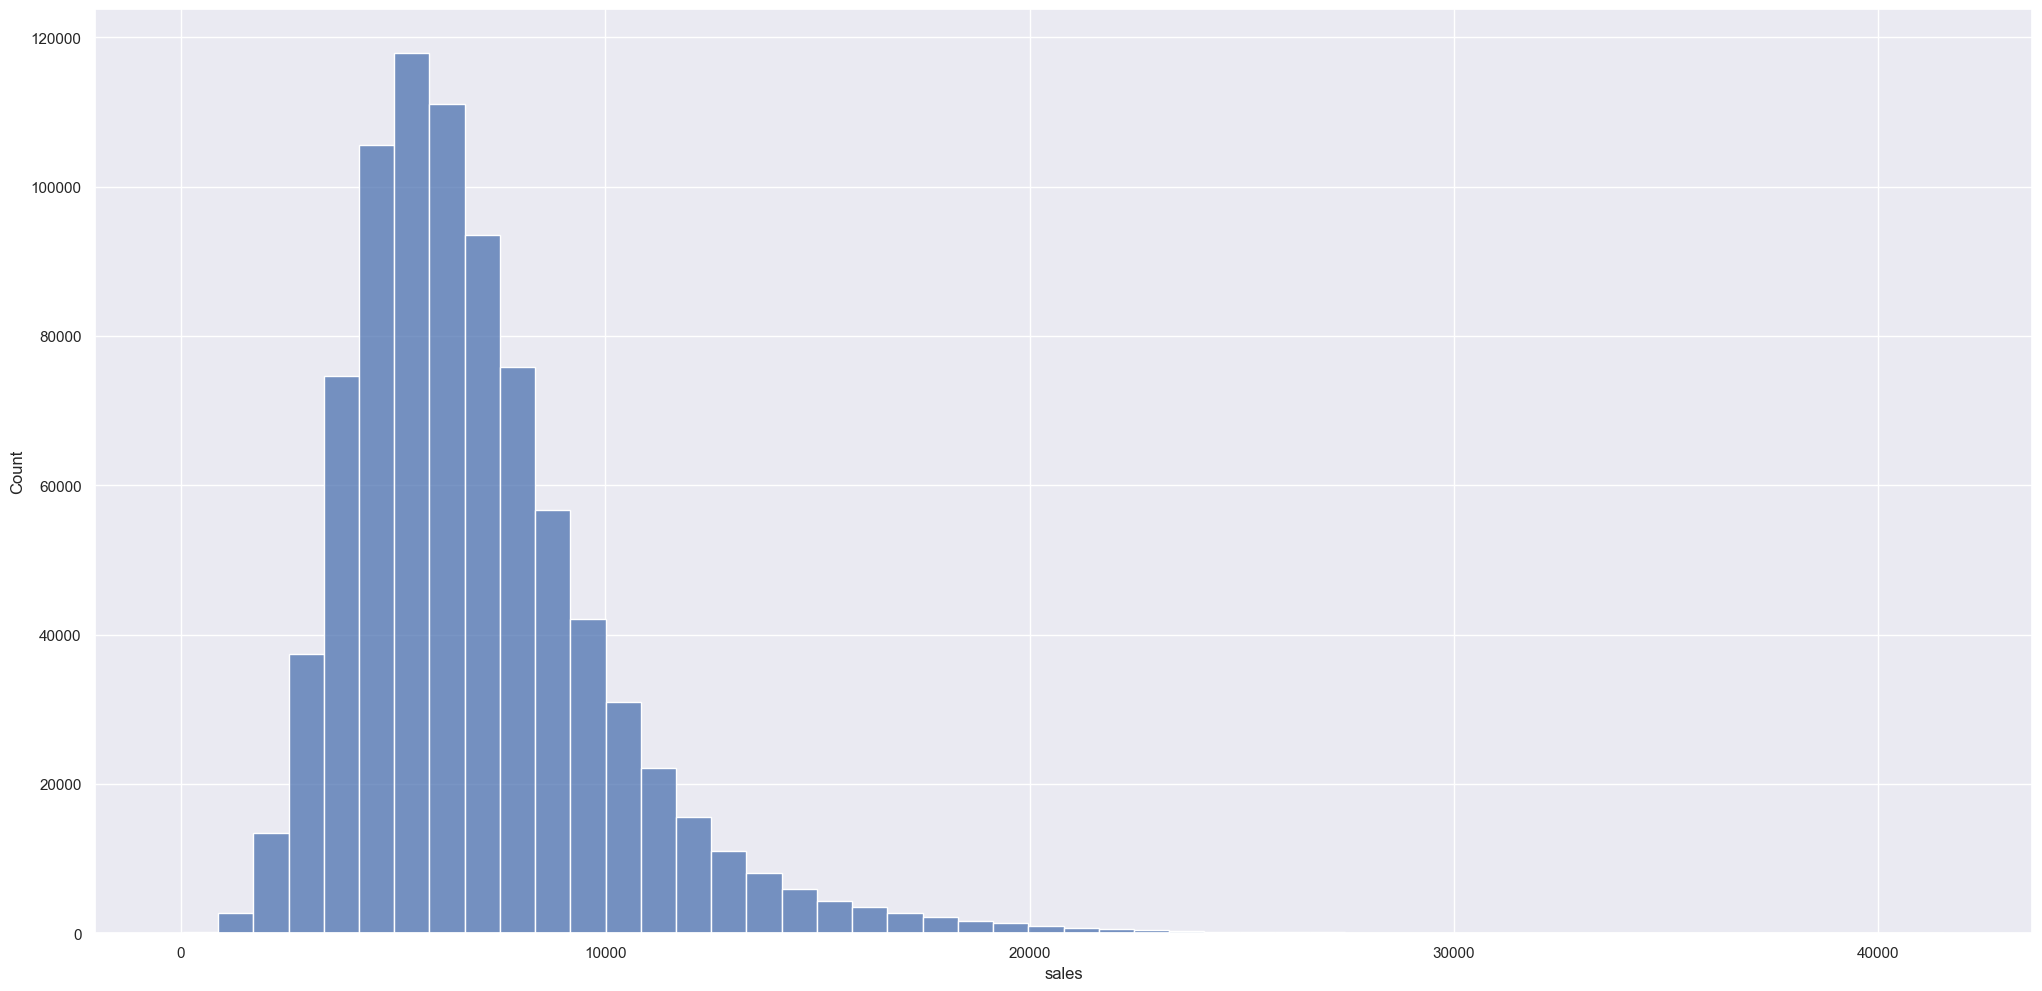

In [44]:
sns.histplot(df4['sales'], bins = 50);

### 4.1.2 Numerical variable

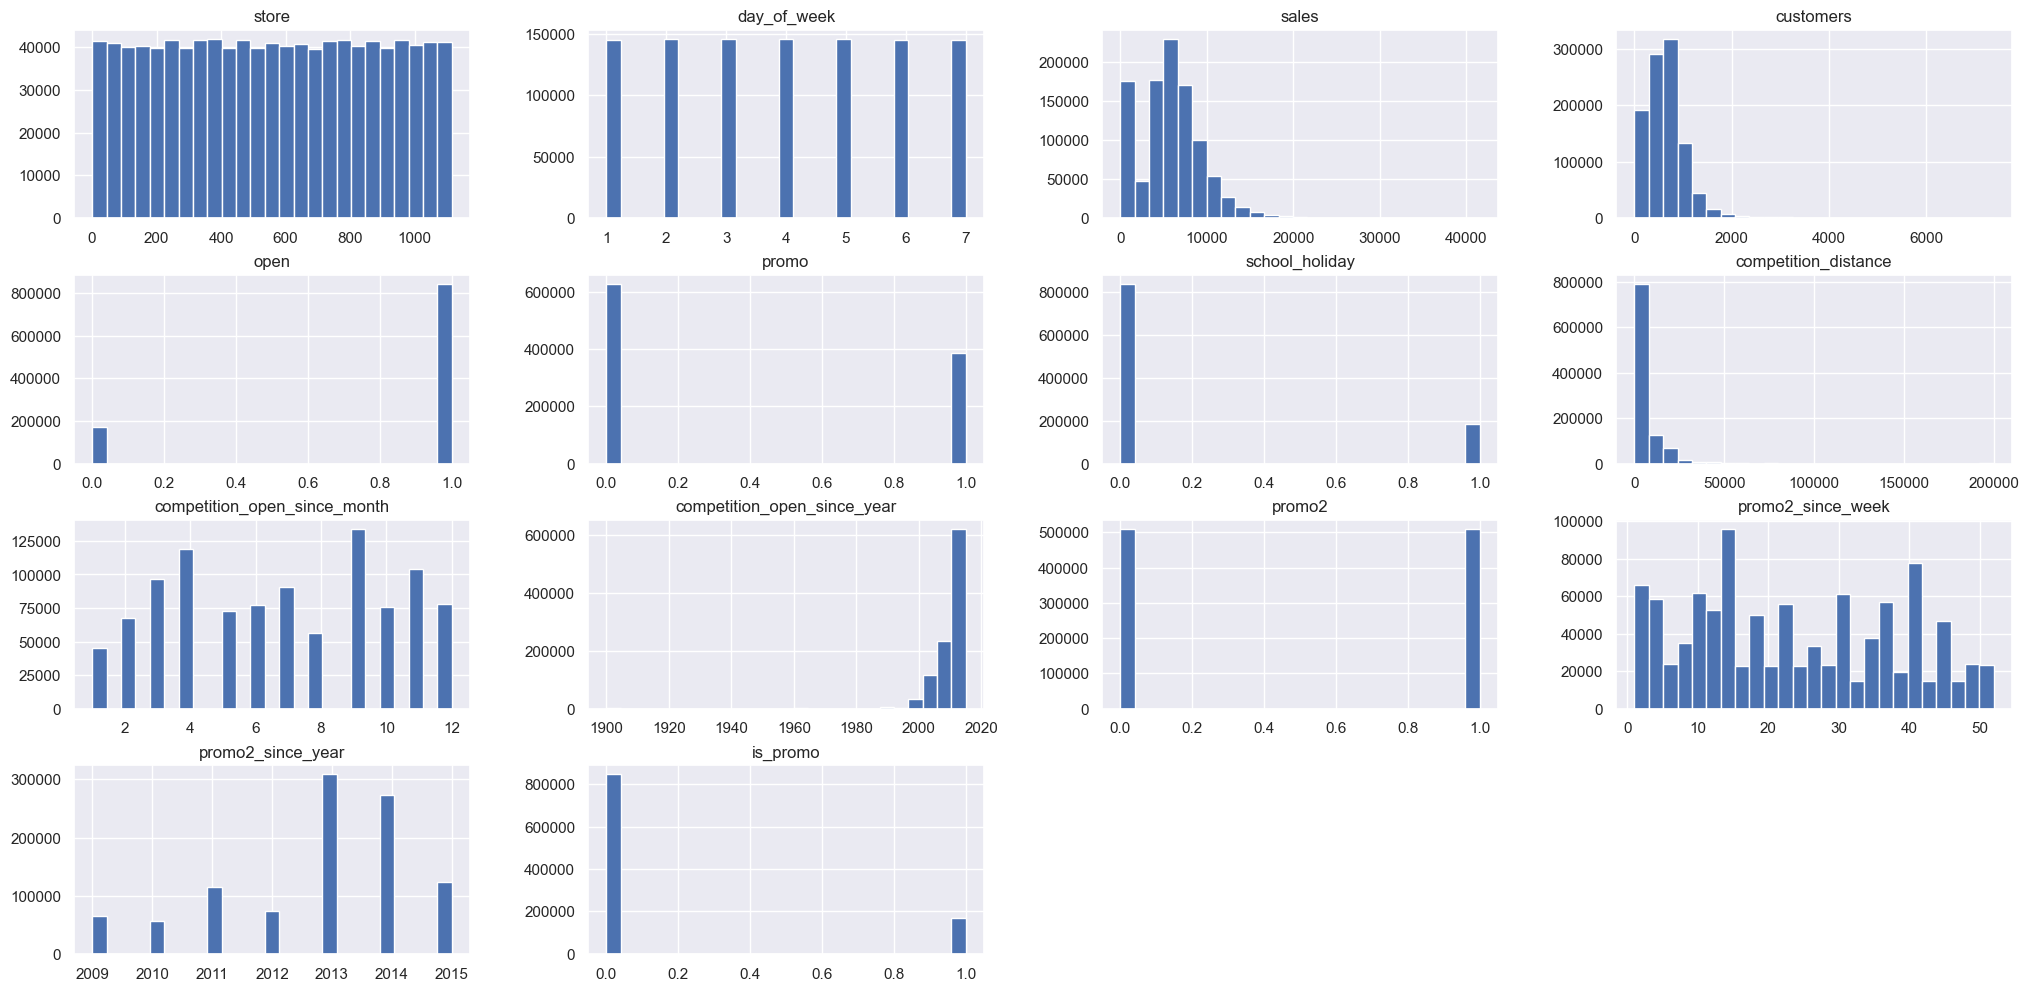

In [45]:
num_attributes.hist(bins = 25);

### 4.1.3 Categorical variable

In [46]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

C:\Users\Admin\AppData\Local\Temp\ipykernel_4204\2395258187.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = a, x= 'state_holiday', palette = 'Set2'


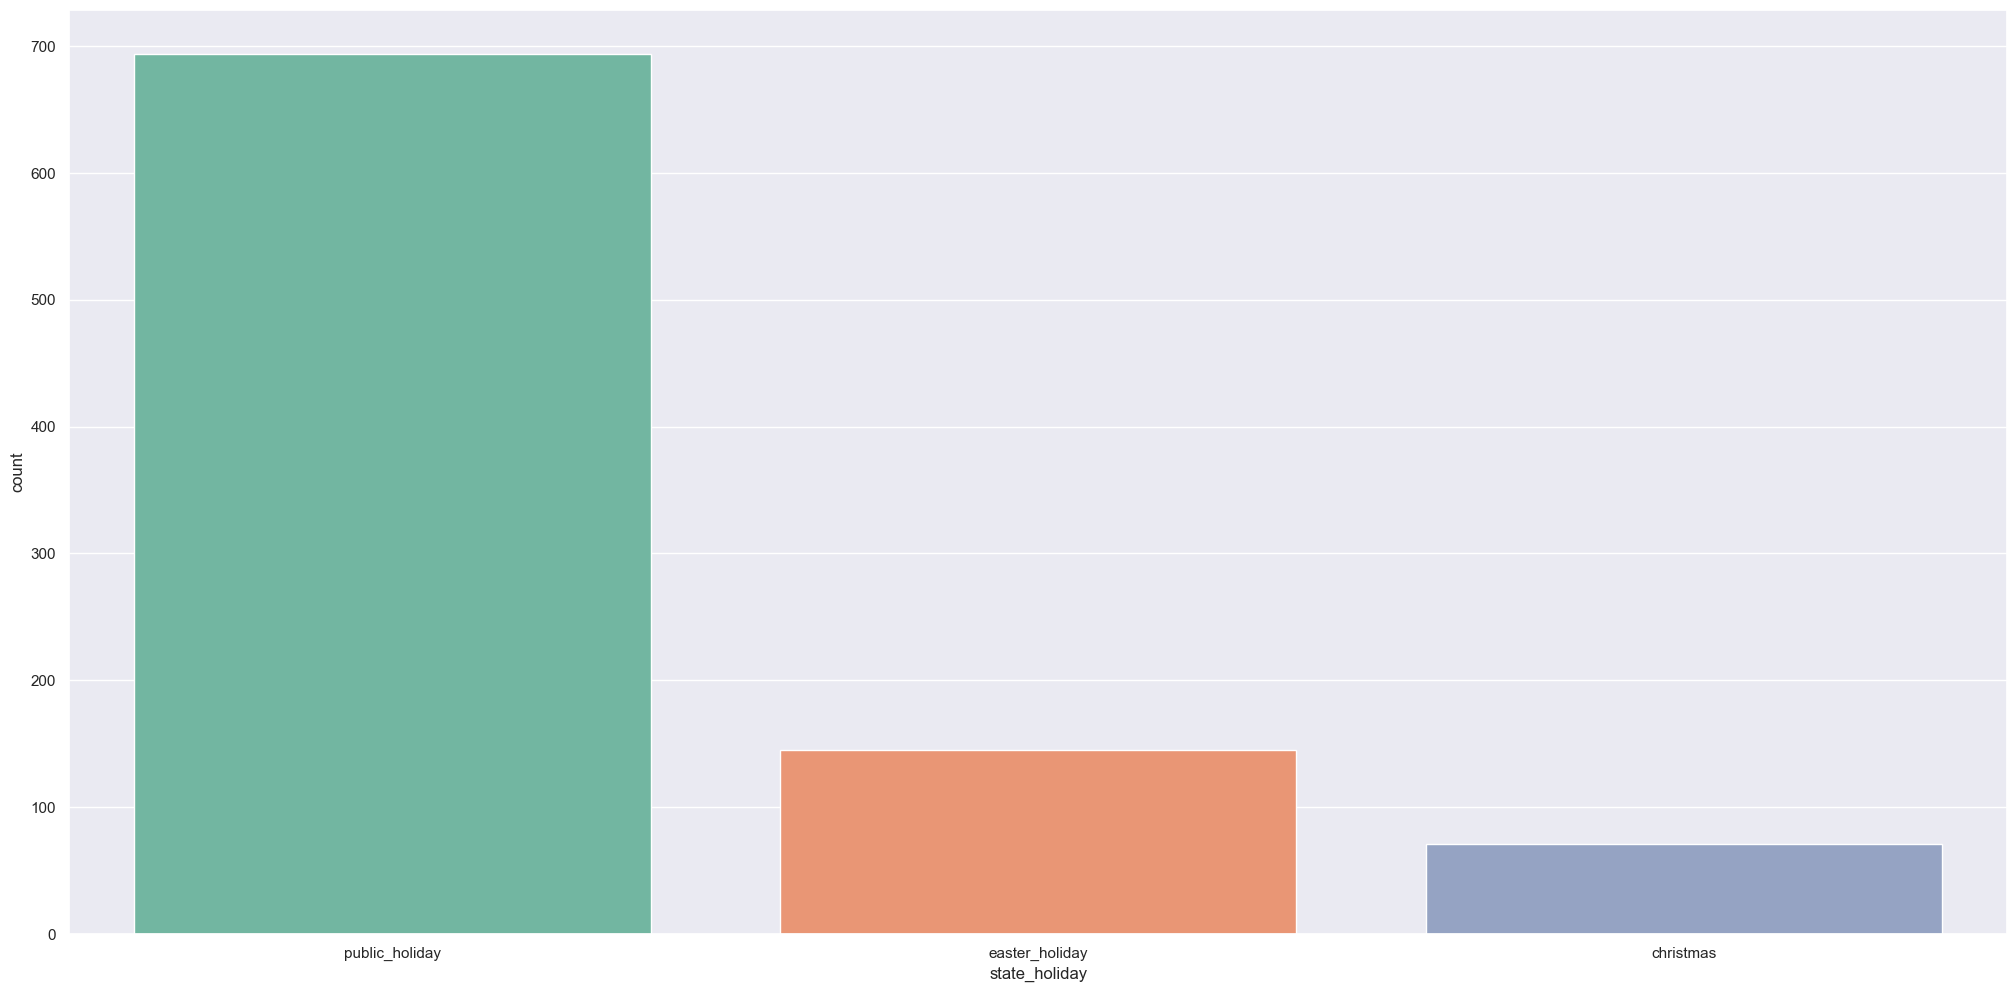

In [47]:
# state_holiday
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(data = a, x= 'state_holiday', palette = 'Set2'
            
             );


## 4.2 Análise bivariada

## 4.3 Análise multivariada